In [3]:
#pip install tensorflow

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [57]:
from sklearn.metrics import r2_score

# Modelos de Prediccion (2007-2021)

In [5]:
def csv_folder_to_dataframes(input_folder):
    # Ensure input folder exists
    if not os.path.exists(input_folder):
        print(f"Input folder '{input_folder}' does not exist.")
        return
    
    # List all files in the input folder
    files = os.listdir(input_folder)
    
    # Filter out only the CSV files
    csv_files = [f for f in files if f.endswith('.csv')]
    
    # Create a dictionary to store DataFrames with their names
    dataframes = {}
    
    # Convert each CSV file to DataFrame and store with the same name
    for csv_file in csv_files:
        csv_file_path = os.path.join(input_folder, csv_file)
        dataframe = pd.read_csv(csv_file_path)
        dataframe_name = os.path.splitext(csv_file)[0]  # Remove the .csv extension
        dataframes[dataframe_name] = dataframe
    
    return dataframes

In [8]:
input_folder = "../data/clean_data/data_preliminar"

dataframes = csv_folder_to_dataframes(input_folder)

In [9]:
def missing_values_count(dataframes):
    for name, df in dataframes.items():
        # Count missing values before dropping
        missing_before = df.isnull().sum().sum()
        
        
        # Print the counts
        print(f"DataFrame: {name}")
        print(f"Missing values: {missing_before}")
#        print(f"Missing values after dropping: {missing_after}")
        print("-----------------------------")

In [10]:
missing_values_count(dataframes)

DataFrame: cerro_prieto
Missing values: 0
-----------------------------
DataFrame: el_cuchillo
Missing values: 0
-----------------------------
DataFrame: la_boca
Missing values: 0
-----------------------------


In [11]:
dataframes['el_cuchillo']

,Fecha,Almacenamiento (hm3),Precipitacion (mm),T_Max (C),T_Min (C),Evaporacion (mm),Extracciones por Obra de Toma (m3/s),Extracciones por Vertedor (m3/s)
0,1/1/2008,1120.450,0.0,13.5,11.0,3.73,3.220,0.0
1,1/2/2008,1117.752,0.0,9.0,6.5,4.83,4.730,0.0
2,1/3/2008,1117.752,0.0,16.5,-0.5,3.13,3.130,0.0
3,1/4/2008,1116.404,0.0,22.0,-1.0,2.02,4.260,0.0
4,1/5/2008,1116.404,0.0,24.0,4.0,2.14,4.220,0.0
...,...,...,...,...,...,...,...,...
4744,12/27/2020,1084.060,0.0,27.0,5.0,5.35,2.683,0.0
4745,12/28/2020,1084.060,0.0,29.5,12.0,3.63,4.202,0.0
4746,12/29/2020,1082.710,0.0,30.0,12.5,3.75,5.108,0.0
4747,12/30/2020,1082.710,0.0,30.0,15.0,4.20,5.596,0.0


### LSTM para El Cuchillo univariada
Data de input es solamente la serie de tiempo de Almacenamiento buscando prediccion en t+x

In [13]:
serie = dataframes['el_cuchillo']['Almacenamiento (hm3)'].values

In [14]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
serie_escalada = scaler.fit_transform(serie.reshape(-1, 1))

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(serie_escalada) * 0.8)
train, test = serie_escalada[:train_size], serie_escalada[train_size:]

In [15]:
def crear_datos(serie, look_back=1):
    X, y = [], []
    for i in range(len(serie)-look_back-1):
        a = serie[i:(i+look_back), 0]
        X.append(a)
        y.append(serie[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10  # Número de pasos atrás a considerar
X_train, y_train = crear_datos(train, look_back)
X_test, y_test = crear_datos(test, look_back)

# Reshape para LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], look_back, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1)


In [16]:
# Definir el modelo
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)


Epoch 1/100


C:\Users\jacal\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3788/3788 - 8s - 2ms/step - loss: 9.6160e-04
Epoch 2/100
3788/3788 - 7s - 2ms/step - loss: 2.4677e-04
Epoch 3/100
3788/3788 - 6s - 2ms/step - loss: 1.2710e-04
Epoch 4/100
3788/3788 - 7s - 2ms/step - loss: 9.6761e-05
Epoch 5/100
3788/3788 - 7s - 2ms/step - loss: 7.9759e-05
Epoch 6/100
3788/3788 - 7s - 2ms/step - loss: 7.2103e-05
Epoch 7/100
3788/3788 - 7s - 2ms/step - loss: 6.8606e-05
Epoch 8/100
3788/3788 - 9s - 2ms/step - loss: 8.0584e-05
Epoch 9/100
3788/3788 - 9s - 2ms/step - loss: 6.3975e-05
Epoch 10/100
3788/3788 - 8s - 2ms/step - loss: 6.6323e-05
Epoch 11/100
3788/3788 - 9s - 2ms/step - loss: 5.5780e-05
Epoch 12/100
3788/3788 - 9s - 2ms/step - loss: 5.7233e-05
Epoch 13/100
3788/3788 - 8s - 2ms/step - loss: 6.0032e-05
Epoch 14/100
3788/3788 - 8s - 2ms/step - loss: 5.5629e-05
Epoch 15/100
3788/3788 - 8s - 2ms/step - loss: 5.5019e-05
Epoch 16/100
3788/3788 - 7s - 2ms/step - loss: 5.2849e-05
Epoch 17/100
3788/3788 - 6s - 2ms/step - loss: 5.3630e-05
Epoch 18/100
3788/3788 - 7s - 2ms/s

In [17]:
# Realizar predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir el escalado de los datos
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calcular el error RMSE
from sklearn.metrics import mean_squared_error
train_score = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
print(f'Error de entrenamiento: {train_score:.2f} RMSE')
print(f'Error de prueba: {test_score:.2f} RMSE')


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Error de entrenamiento: 6.59 RMSE
Error de prueba: 10.24 RMSE


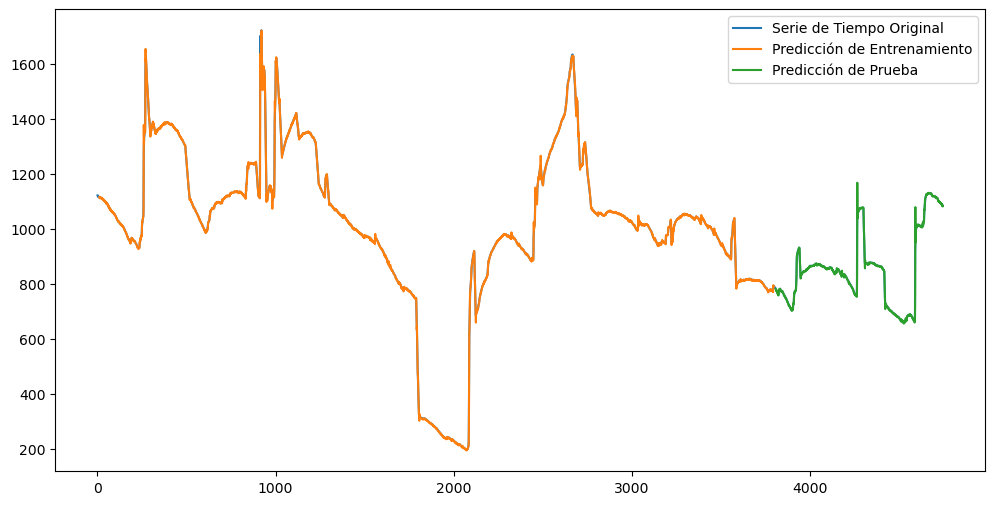

In [18]:
# Desplazar las predicciones para visualización
train_predict_plot = np.empty_like(serie_escalada)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

test_predict_plot = np.empty_like(serie_escalada)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(serie_escalada)-1, :] = test_predict

# Plot
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(serie_escalada), label='Serie de Tiempo Original')
plt.plot(train_predict_plot, label='Predicción de Entrenamiento')
plt.plot(test_predict_plot, label='Predicción de Prueba')
plt.legend()
plt.show()


### LSTM para El Cuchillo multivariada
Data de input son las series de tiempo de Almacenamiento, Temperaturas y Precipitacion

In [42]:
data = dataframes['el_cuchillo'][['Almacenamiento (hm3)','Precipitacion (mm)','T_Max (C)','T_Min (C)']]

In [43]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convertir a DataFrame para mayor comodidad
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

# Definir una función para crear la secuencia de datos
def crear_datos_multivariados(data, target_col, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:(i + look_back)].values)
        y.append(data.iloc[i + look_back][target_col])
    return np.array(X), np.array(y)

look_back = 10  # Número de pasos atrás a considerar
X, y = crear_datos_multivariados(scaled_data, target_col='Almacenamiento (hm3)', look_back=look_back)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Escalar solo la columna objetivo por separado
scaler_target = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))


In [44]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(look_back, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train_scaled, epochs=100, batch_size=1, verbose=2)


Epoch 1/100


C:\Users\jacal\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3791/3791 - 8s - 2ms/step - loss: 0.0015
Epoch 2/100
3791/3791 - 7s - 2ms/step - loss: 2.7237e-04
Epoch 3/100
3791/3791 - 7s - 2ms/step - loss: 1.4320e-04
Epoch 4/100
3791/3791 - 6s - 2ms/step - loss: 1.2297e-04
Epoch 5/100
3791/3791 - 7s - 2ms/step - loss: 1.0808e-04
Epoch 6/100
3791/3791 - 7s - 2ms/step - loss: 8.9773e-05
Epoch 7/100
3791/3791 - 6s - 2ms/step - loss: 7.7577e-05
Epoch 8/100
3791/3791 - 7s - 2ms/step - loss: 7.5818e-05
Epoch 9/100
3791/3791 - 6s - 2ms/step - loss: 7.3178e-05
Epoch 10/100
3791/3791 - 6s - 2ms/step - loss: 6.3313e-05
Epoch 11/100
3791/3791 - 6s - 2ms/step - loss: 6.8320e-05
Epoch 12/100
3791/3791 - 7s - 2ms/step - loss: 6.2006e-05
Epoch 13/100
3791/3791 - 6s - 2ms/step - loss: 6.5781e-05
Epoch 14/100
3791/3791 - 7s - 2ms/step - loss: 6.6458e-05
Epoch 15/100
3791/3791 - 7s - 2ms/step - loss: 6.0546e-05
Epoch 16/100
3791/3791 - 7s - 2ms/step - loss: 5.8707e-05
Epoch 17/100
3791/3791 - 7s - 2ms/step - loss: 6.0204e-05
Epoch 18/100
3791/3791 - 8s - 2ms/step 

In [46]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler_target.inverse_transform(train_predict)
y_train_inv = scaler_target.inverse_transform(y_train_scaled)
test_predict = scaler_target.inverse_transform(test_predict)
y_test_inv = scaler_target.inverse_transform(y_test_scaled)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [47]:
train_score = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_score = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Error de entrenamiento: {train_score:.2f} RMSE')
print(f'Error de prueba: {test_score:.2f} RMSE')

Error de entrenamiento: 0.00 RMSE
Error de prueba: 0.01 RMSE


In [55]:
y_train_inv

array([[0.60204959],
       [0.60116556],
       [0.60116556],
       ...,
       [0.39045089],
       [0.39045089],
       [0.38980802]])

In [54]:
test_predict

array([[0.39305282],
       [0.39237744],
       [0.3917212 ],
       [0.3910946 ],
       [0.3905182 ],
       [0.38980395],
       [0.3892173 ],
       [0.38856393],
       [0.3879707 ],
       [0.38631716],
       [0.38505852],
       [0.38470173],
       [0.38330126],
       [0.38359576],
       [0.38196138],
       [0.38051704],
       [0.38013318],
       [0.37843204],
       [0.37702313],
       [0.37699255],
       [0.37528256],
       [0.37520677],
       [0.3744073 ],
       [0.3744938 ],
       [0.3749196 ],
       [0.3773422 ],
       [0.38458517],
       [0.38392928],
       [0.38526753],
       [0.38535914],
       [0.38617313],
       [0.38687563],
       [0.38764733],
       [0.388312  ],
       [0.38691902],
       [0.38613528],
       [0.38437197],
       [0.3831404 ],
       [0.38174266],
       [0.38135147],
       [0.3820404 ],
       [0.3830296 ],
       [0.3807745 ],
       [0.38271597],
       [0.38232002],
       [0.38188124],
       [0.38201243],
       [0.379

In [51]:
data['Fecha'] = pd.date_range(start='1/1/2008', periods=len(data), freq='D')  # Ajusta según tu frecuencia
data['Predicción de Entrenamiento'] = np.nan
data['Predicción de Prueba'] = np.nan

data['Predicción de Entrenamiento'][look_back:len(train_predict)+look_back] = train_predict.flatten()
data['Predicción de Prueba'][len(train_predict)+(look_back*2)+1:len(data)-1] = test_predict.flatten()

# Convertir el DataFrame a formato largo para facilitar la visualización con Altair
data_long = data.melt('Fecha', var_name='Tipo', value_name='Valor')

C:\Users\jacal\AppData\Local\Temp\ipykernel_25468\438184257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fecha'] = pd.date_range(start='1/1/2008', periods=len(data), freq='D')  # Ajusta según tu frecuencia
C:\Users\jacal\AppData\Local\Temp\ipykernel_25468\438184257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicción de Entrenamiento'] = np.nan
C:\Users\jacal\AppData\Local\Temp\ipykernel_25468\438184257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

ValueError: cannot set using a slice indexer with a different length than the value

In [50]:
# Desplazar las predicciones para visualización
train_predict_plot = np.empty_like(serie_escalada)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

test_predict_plot = np.empty_like(serie_escalada)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(serie_escalada)-1, :] = test_predict

ValueError: could not broadcast input array from shape (948,1) into shape (936,1)

In [52]:
data

,Almacenamiento (hm3),Precipitacion (mm),T_Max (C),T_Min (C),Fecha,Predicción de Entrenamiento,Predicción de Prueba
0,1120.450,0.0,13.5,11.0,2008-01-01,NaN,NaN
1,1117.752,0.0,9.0,6.5,2008-01-02,NaN,NaN
2,1117.752,0.0,16.5,-0.5,2008-01-03,NaN,NaN
3,1116.404,0.0,22.0,-1.0,2008-01-04,NaN,NaN
4,1116.404,0.0,24.0,4.0,2008-01-05,NaN,NaN
...,...,...,...,...,...,...,...
4744,1084.060,0.0,27.0,5.0,2020-12-27,NaN,NaN
4745,1084.060,0.0,29.5,12.0,2020-12-28,NaN,NaN
4746,1082.710,0.0,30.0,12.5,2020-12-29,NaN,NaN
4747,1082.710,0.0,30.0,15.0,2020-12-30,NaN,NaN
